In [1]:
import numpy as np
import math
import dynesty
import matplotlib.pyplot as plt

## Signal injection

Text(0, 0.5, 'Timing resduals, s')

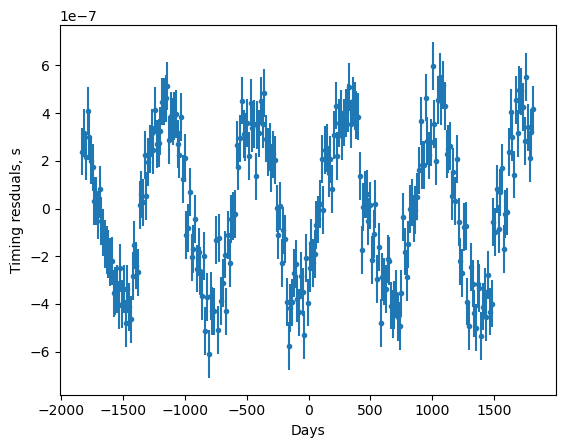

In [2]:
#simple sine wave, which is essentialy a continuous GW from a single supermassive black hole binary
def gw_sig(logh, log_omega, phase, time, err):
  det_sig = 10**logh/10**log_omega * np.sin(10**log_omega * time + phase)
  #plus white noise
  det_sig += err * np.random.randn(len(time))
  return det_sig

#define the injected parameters
logh_true = -13.4 # dimensionless amplitude h
log_omega_true = -7. # Hz
phase_true = np.random.uniform(0, 2. * np.pi) #initialize random phase


err = 100. * 1e-9 #100 ns
time = np.arange(-365.25 * 5., 365.25 * 5., 14.) # 10 years of observations every 14 days
y = gw_sig(logh_true, log_omega_true, phase_true, time * 24. *3600., err)

plt.errorbar(time, y, err, fmt = ".")
plt.xlabel("Days")
plt.ylabel("Timing resduals, s")

## Likelihood construction and evaluation

### Construct a prior. 
u is a Uniformly distributed varaible [0, 1].

In [3]:
def prior_transform(u):
    v = u * 3
    v[0] = u[0] * 8 - 20 # [-20, -12]
    v[1] = .... # [-9, -5]
    v[2] = .... # [0, 2pi]
    return v

### Construct a simple Gaussian likelhood

In [4]:
def loglike(v):
    logh, log_omega, phase = v
    t = time * 24. * 3600.
    sigma = err
    arg = 10**log_omega * t + phase
    model = 10**logh/10**log_omega * np.sin(arg)
    res = y - model
    loglike = .....
    
    if not np.isfinite(loglike):
        loglike = -1e300
        
    return loglike

## Run the sampler

In [5]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=3, sample='rwalk')
dsampler.run_nested()
dres = dsampler.results

19902it [00:18, 1062.16it/s, batch: 7 | bound: 22 | nc: 23 | ncall: 423039 | eff(%):  4.705 | loglstar: 3810.295 < 3815.362 < 3814.715 | logz: 3797.436 +/-  0.113 | stop:  0.911]      


## Visualize the results

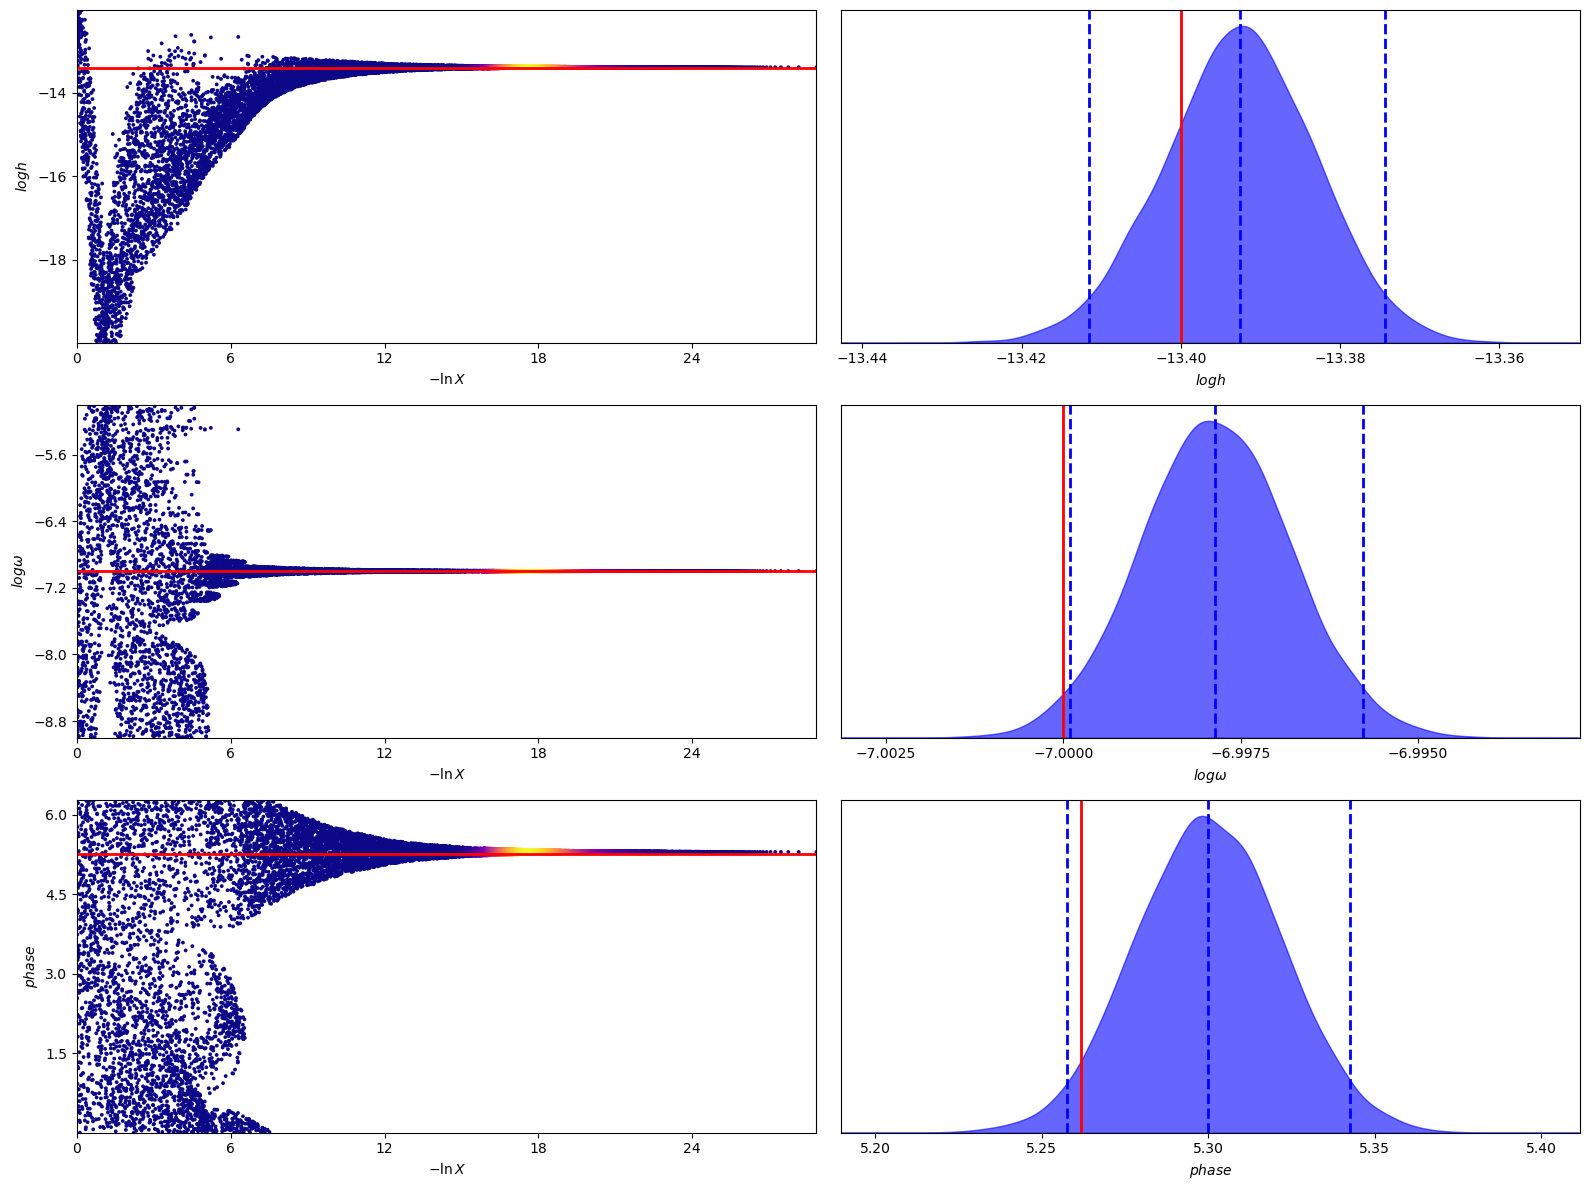

In [6]:
from dynesty import plotting as dyplot

truths = [logh_true, log_omega_true, phase_true]
labels = [r'$logh$', r'$log\omega$', r'$phase$']
fig, axes = dyplot.traceplot(dsampler.results, truths=truths, labels=labels,
                             fig=plt.subplots(3, 2, figsize=(16, 12)))
fig.tight_layout()

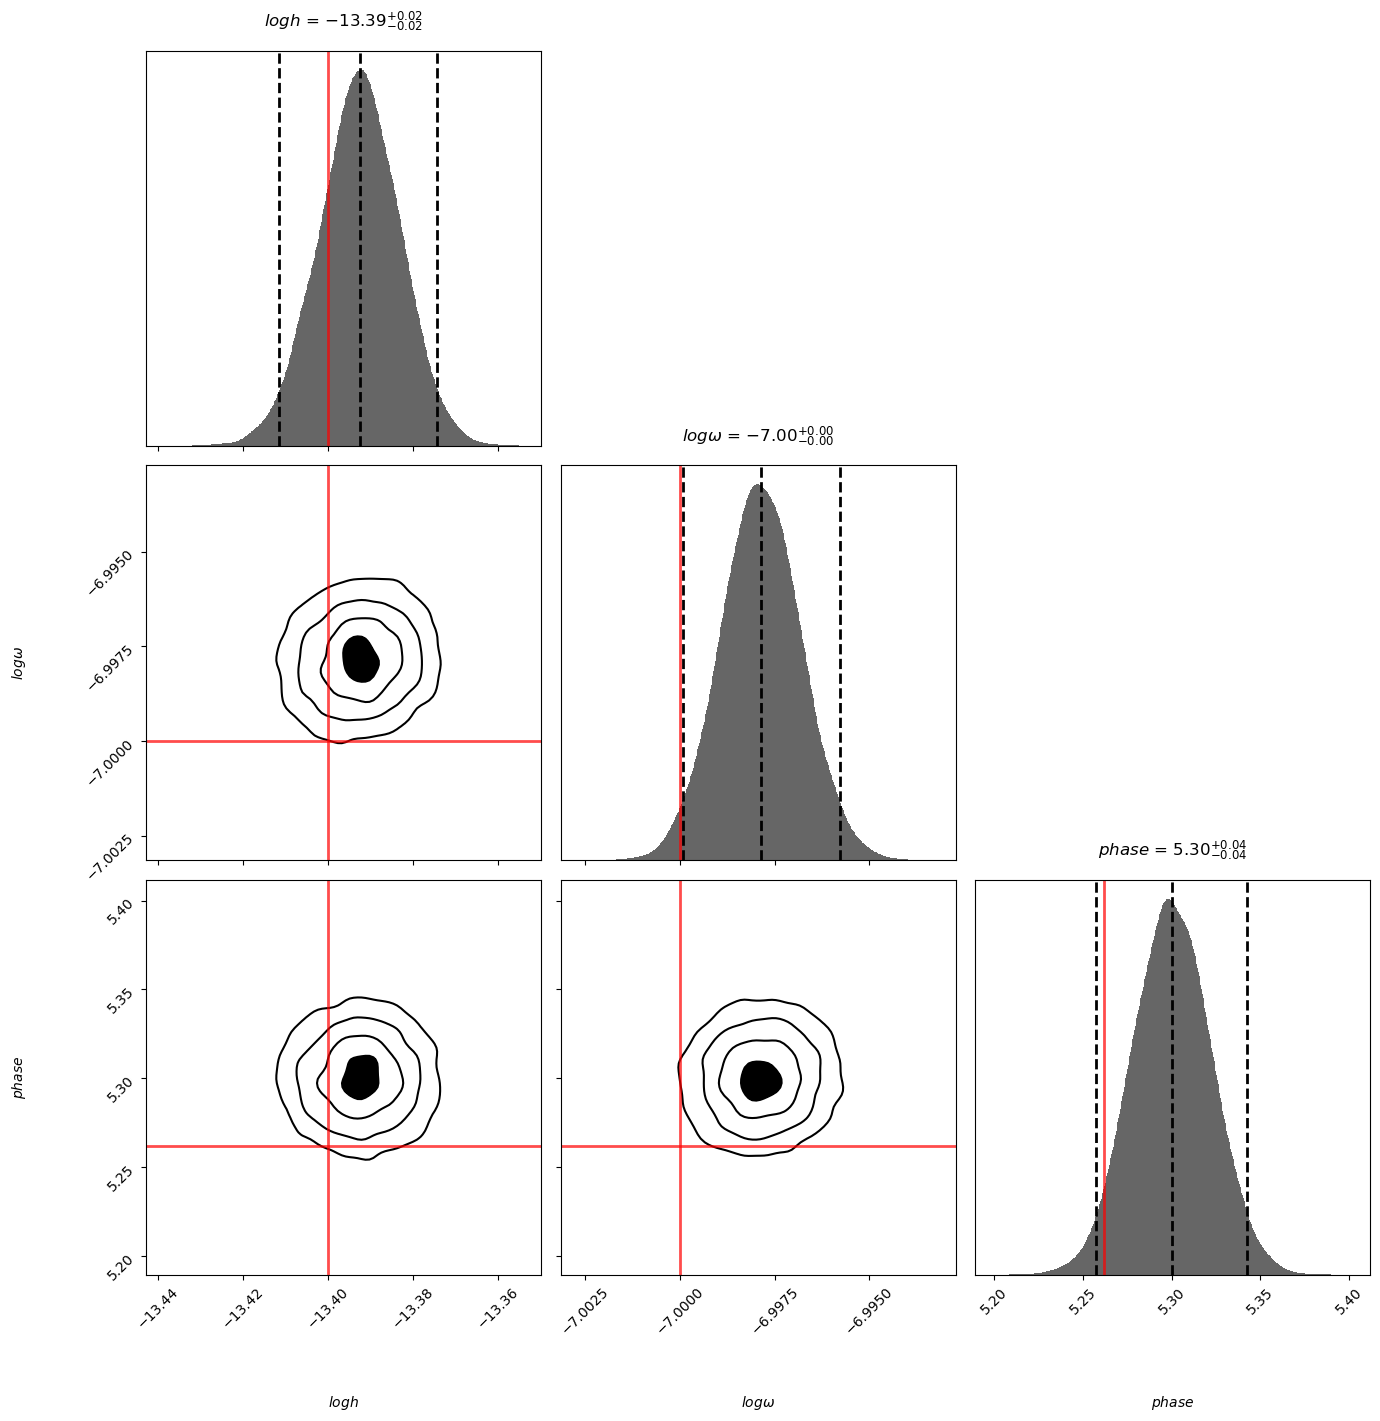

In [7]:
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                          title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(3, 3, figsize=(15, 15)))

## Overestimated uncertainties

1. Generate the signal with extra noise that is not accounted in the determined uncertainties
2. Run the original likelihood and see what happens
3. Modify the likelihood accordingly to take into account extra white noise
4. Compare evidences and decide, which model describes the data better (with or without extra noise)

<ErrorbarContainer object of 3 artists>

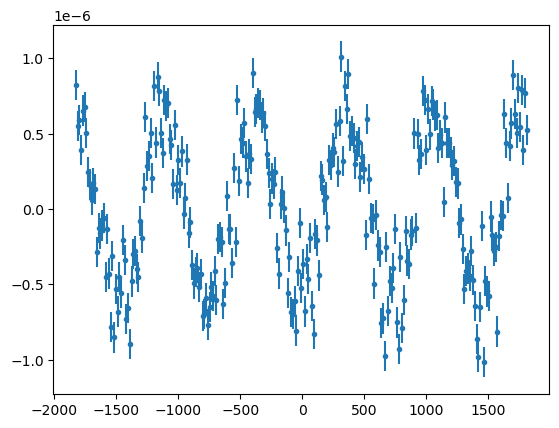

In [8]:
def gw_sig(logh, log_omega, phase, time, err, equad_true):
  det_sig = 10**logh/10**log_omega * np.sin(10**log_omega * time + phase)
  #plus white noise
  det_sig += err * np.random.randn(len(time))
  # add extra wide noise here
  det_sig += equad_true * np.random.randn(len(time))
  return det_sig

logh_true = -13.2 # dimensionless amplitude h
log_omega_true = -7. # Hz
phase_true = np.random.uniform(0, 2. * np.pi)

equad_true = 2e-7
err = 100. * 1e-9 #100 ns
time = np.arange(-365.25 * 5., 365.25 * 5., 14.) # 10 years of observations every 14 days
y = gw_sig(logh_true, log_omega_true, phase_true, time * 24. *3600., err, equad_true)

plt.errorbar(time, y, err, fmt = ".")

In [12]:
def prior_transform(u):
    v = u * 4
    v[0] = u[0] * 7 - 20 #[-20, -12]
    v[1] = u[1] * 4 - 9. # [-9, -5]
    v[2] = u[2] * 2 * np.pi #[0, 2pi]
    v[3] = u[3] * 1 #[0, 1]
    return v

def loglike(v):
    
    ........
    
    if not np.isfinite(loglike):
        loglike = -1e300
        
    return loglike

In [13]:
dsampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=4, sample='rwalk')
dsampler.run_nested()
dres = dsampler.results

29743it [00:33, 886.59it/s, batch: 6 | bound: 21 | nc: 24 | ncall: 677370 | eff(%):  4.391 | loglstar: 3635.788 < 3641.352 < 3640.120 | logz: 3603.336 +/-  0.172 | stop:  0.889]        


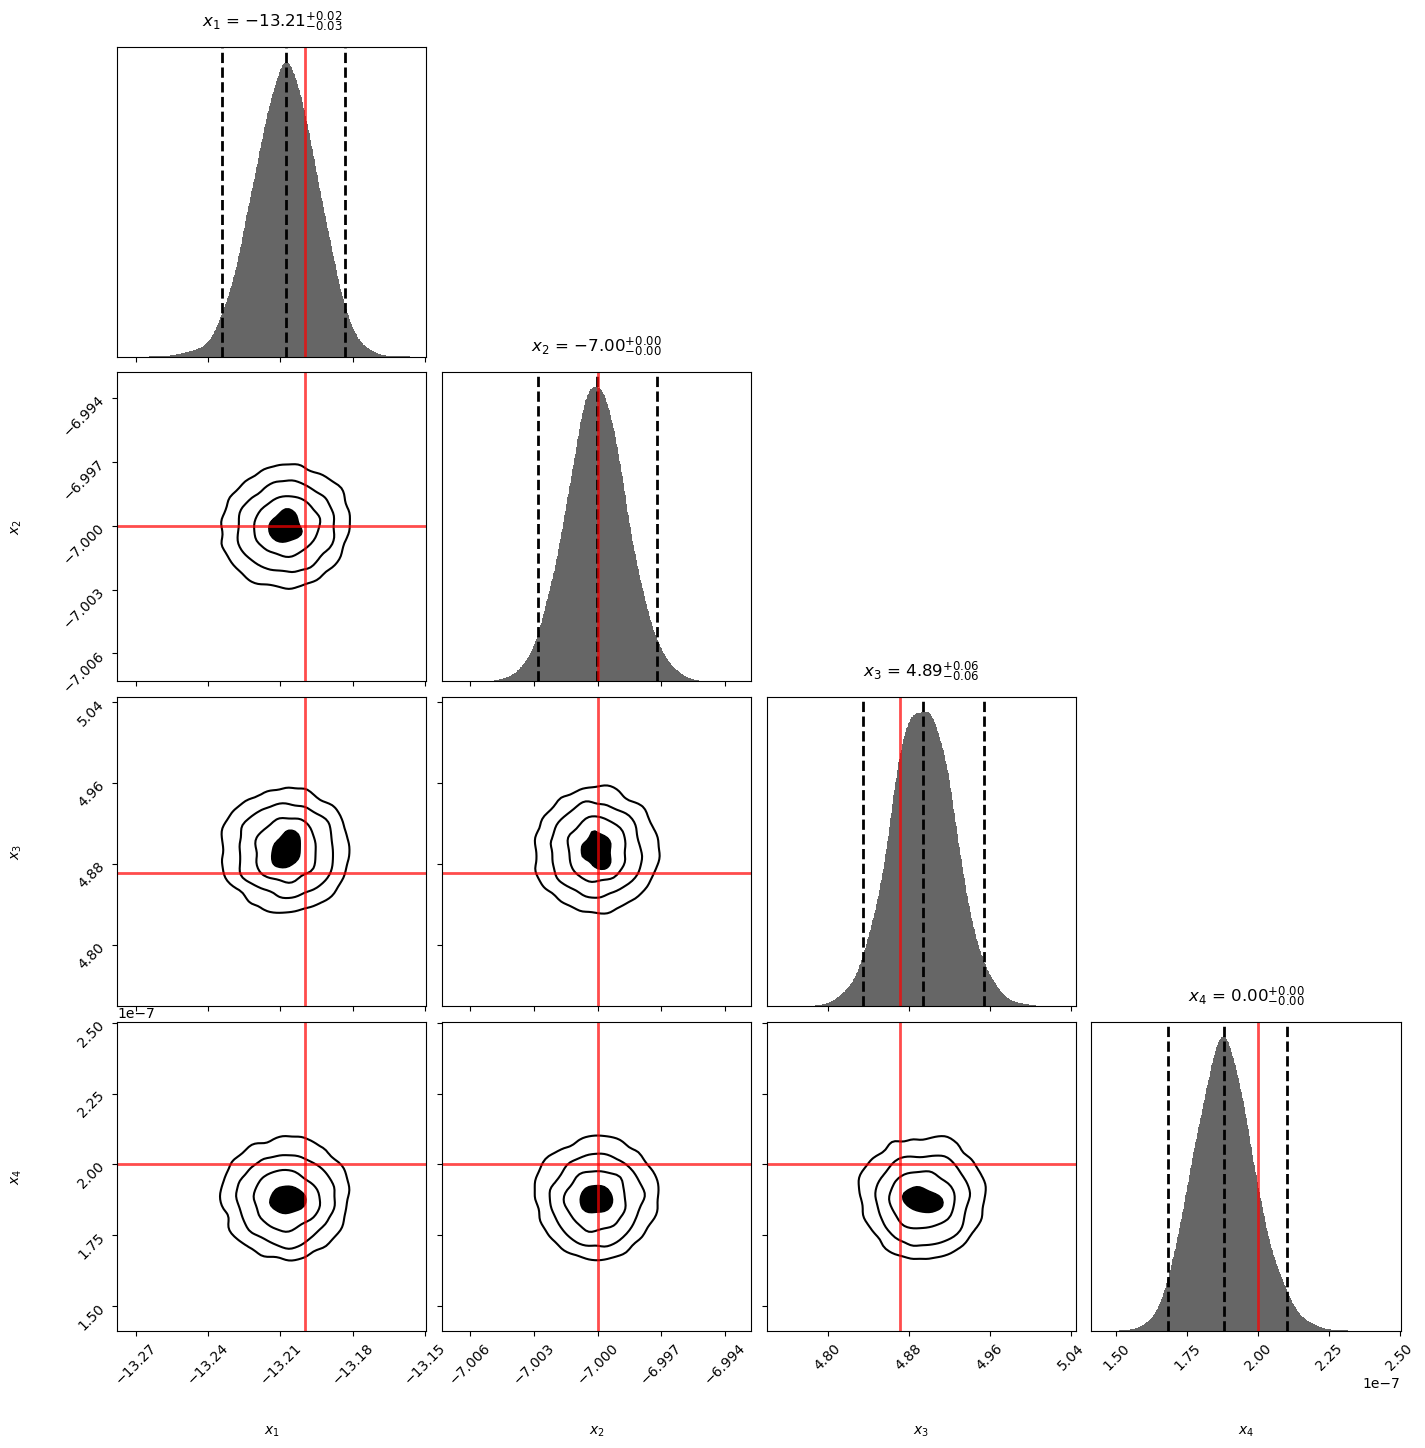

In [14]:
.........

## Detecting stochastic signal (GWB) in the noisy data

1. Generate the stochastic signal
2. Check how it looks in the frequency domain. What is the difference between white and red noise?
3. What is the covariance matric of the Lorentzian spectrum?
4. Construct the likelihood function which includes the stochastic process

0.0


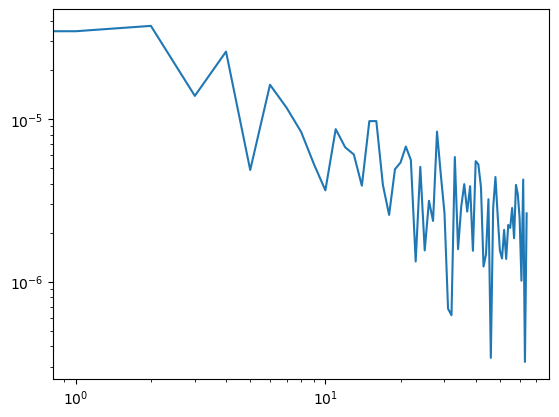

In [16]:
from numpy import linalg

def construct_covariance_matrix(theta, time, err):
    logA, log_f0 = theta
    cov_wn = err**2*np.diag(np.ones(len(time)))
    tau = np.asarray([[2.*np.pi*abs(time[i]-time[j]) for i in range(len(time))] for j in range(len(time))]) 
    cov_rn = 10**(logA) * np.exp(- 10**log_f0 * tau)
    return cov_wn + cov_rn

def gwb_sig(logA, log_f0, time, err):
   theta0 = [logA, log_f0]
   mean = np.zeros(len(time))
   cov = construct_covariance_matrix(theta0, time, err)

   #construct a signal with multivariate normal function
   stoch_sig = np.random.multivariate_normal(mean, cov)
   #plus white noise
   return stoch_sig

logA_true = -12.1 # dimensionless amplitude h
log_f0_true = -8.1 # Hz
err = 100. * 1e-9 #100 ns
time = np.arange(0., 365.25 * 10., 28.) # 10 years of observations every 28 days
y = gwb_sig(logA_true, log_f0_true, time * 24. *3600., err)


## Construct fft of the signal

## Constrcut prior and likelihood

In [20]:
def prior_transform(u):
    v = u * 2
    v[0] = u[0] * 10 - 20
    v[1] = u[1] * 4 - 9.
    return v

def loglike(v):
    theta = v
    t = time * 24. * 3600.
    res = y
    ndim = len(theta)
    C = construct_covariance_matrix(theta, t, err)
    det_sign, det_log_value = linalg.slogdet(C)
    Cinv = linalg.inv(C)
    loglike = ......
    
    if not np.isfinite(loglike):
        loglike = -1e300
        
    return loglike

## Run sampler

In [18]:
dsampler = dynesty.NestedSampler(loglike, prior_transform, ndim=2,
                                         sample='rwalk')
dsampler.run_nested(dlogz = 1.0)
dres = dsampler.results

3416it [20:06,  2.83it/s, +500 | bound: 22 | nc: 1 | ncall: 54061 | eff(%):  7.311 | loglstar:   -inf < 1862.841 <    inf | logz: 1856.231 +/-  0.110 | dlogz:  0.002 >  1.000]


## Visualize the results

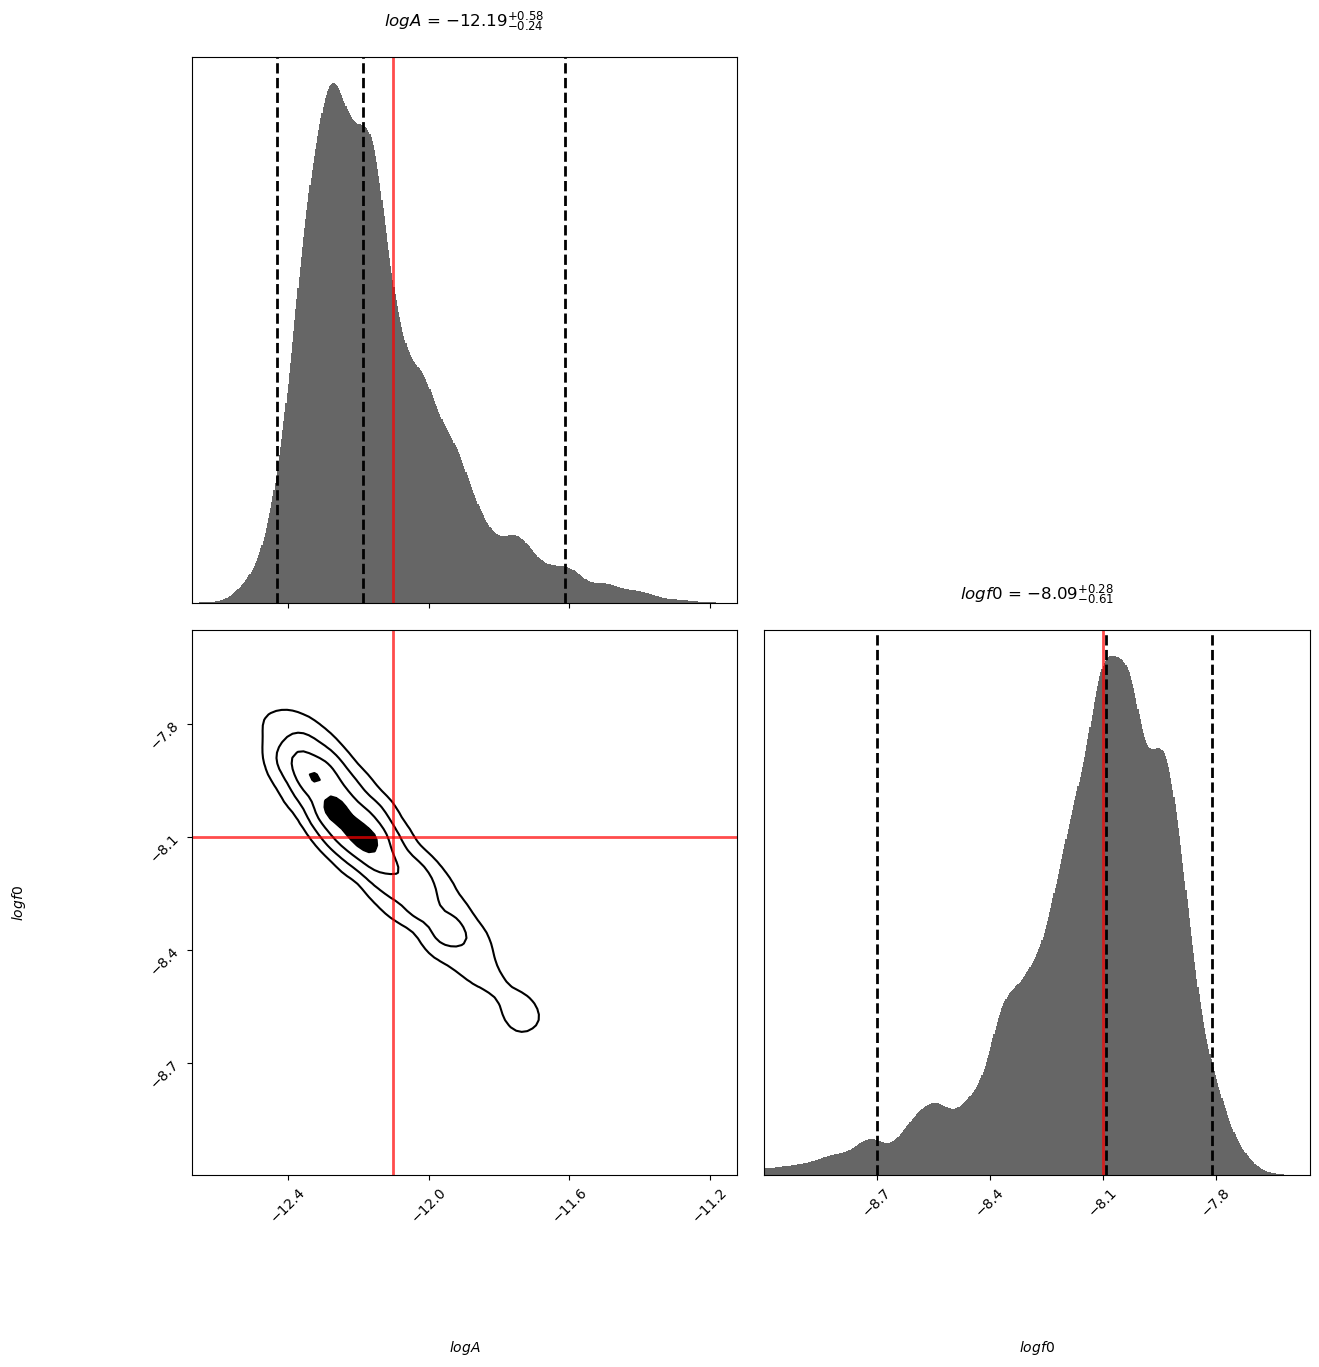

In [21]:
from dynesty import plotting as dyplot
truths = [logA_true, log_f0_true]
ndim = len(truths)
labels = [r'$logA$', r'$log f0$']
fig, axes = dyplot.cornerplot(dres, truths=truths, show_titles=True, 
                              title_kwargs={'y': 1.04}, labels=labels,
                              fig=plt.subplots(ndim, ndim, figsize=(15, 15)))